In [1]:
import matplotlib.pyplot as plt
from lvmsurveysim import IFU, Telescope
from lvmsurveysim.schedule import ObservingPlan, Simulator, TileDB, OpsDB
from lvmsurveysim.target import TargetList
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import PercentileInterval, SqrtStretch, ImageNormalize
from astropy import units as u

In [2]:
with open('./carina.yaml', 'r') as f:
    print(f.read())

Carina:
   coords: [287.46, -0.8]
   region_type: rectangle
   frame: galactic
   region_params:
       width: 2.0
       height: 2.0
       pa: 0
   priority: 9
   observatory: LCO
   telescope: LVM-160
   max_airmass: 1.75
   min_shadowheight: 1000.0
   exptime: 900
   n_exposures: 1
   min_exposures: 1
   min_moon_dist: 60
   max_lunation: 1.0
   overhead: 1.1
   tiling_strategy: lowest_airmass
   tile_overlap: 0.0416



In [3]:
targets = TargetList(target_file='./carina.yaml')
OpsDB.init()
print('Tiling Survey ...')
tiledb = TileDB(targets)
tiledb.tile_targets()
OpsDB.create_tables(drop=True)
OpsDB.save_tiledb(tiledb, fits=True, path='carina_tiles', overwrite=True)

Tiling Survey ...
Tiling target Carina


25

In [4]:
tbl = tiledb.tile_table
tbl

TileID,TargetIndex,Target,Telescope,RA,DEC,PA,TargetPriority,TilePriority,AirmassLimit,LunationLimit,HzLimit,MoonDistanceLimit,TotalExptime,VisitExptime,Status
int64,int64,str6,str7,float64,float64,float64,int64,int64,float64,float64,float64,int64,int64,int64,int64
1000001,0,Carina,LVM-160,159.42294483248395,-60.51720847063176,29.386245550864512,9,1,1.75,1.0,1000.0,60,900,900,0
1000002,0,Carina,LVM-160,160.728441426409,-60.8688713663514,388.2605540667231,9,1,1.75,1.0,1000.0,60,900,900,0
1000003,0,Carina,LVM-160,158.9920152406314,-60.1540720068855,29.75500414183448,9,1,1.75,1.0,1000.0,60,900,900,0
1000004,0,Carina,LVM-160,160.2784067409949,-60.50996019334154,388.6472817061298,9,1,1.75,1.0,1000.0,60,900,900,0
1000005,0,Carina,LVM-160,161.59273257804836,-60.85331437315828,387.5113381773241,9,1,1.75,1.0,1000.0,60,900,900,0
1000006,0,Carina,LVM-160,159.83815644270734,-60.14957763445551,29.02545758780425,9,1,1.75,1.0,1000.0,60,900,900,0
1000007,0,Carina,LVM-160,161.13337759791466,-60.49728750636634,387.90747801607444,9,1,1.75,1.0,1000.0,60,900,900,0
1000008,0,Carina,LVM-160,159.40740107774488,-59.78777355681352,29.39537266650373,9,1,1.75,1.0,1000.0,60,900,900,0
1000009,0,Carina,LVM-160,160.6839532323723,-60.13972432517756,388.2949219666822,9,1,1.75,1.0,1000.0,60,900,900,0


In [5]:
ifu = IFU.from_config()
lvm160 = Telescope.from_config('LVM-160')

In [6]:
lvm160.plate_scale

<Quantity 348.42060811 arcsec / mm>

In [7]:
# Load SHASSA image
dat, hdr = fits.getdata('032.fl.fits.gz', header=True)
wcs = WCS(hdr)
print(dat.shape)

(998, 1014)


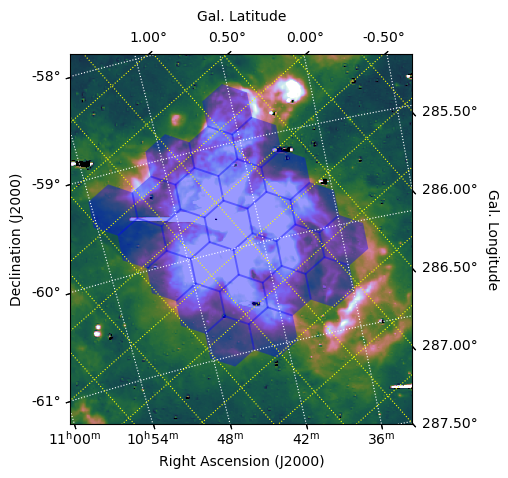

In [12]:
ax = plt.subplot(projection=wcs)
norm = ImageNormalize(dat, interval=PercentileInterval(99),
                      stretch=SqrtStretch())
ax.imshow(dat, origin='lower', cmap='cubehelix', norm=norm)
ax.coords[0].set_axislabel('Right Ascension (J2000)')
ax.coords[1].set_axislabel('Declination (J2000)')
ax.coords[0].set_ticks_position('b')
ax.coords[1].set_ticks_position('l')
ax.grid(color='white', ls=':')
overlay = ax.get_coords_overlay('galactic')
overlay.grid(color='yellow', ls=':')
overlay['l'].set_axislabel('Gal. Longitude')
overlay['l'].set_major_formatter('d.dd')
overlay['l'].set_ticks(spacing=0.5 * u.deg)
overlay['l'].set_ticks_position('r')
overlay['l'].set_ticklabel_position('r')
overlay['l'].set_axislabel_position('r')
overlay['b'].set_axislabel('Gal. Latitude')
overlay['b'].set_major_formatter('d.dd')
overlay['b'].set_ticks(spacing=0.5 * u.deg)
overlay['b'].set_ticks_position('t')
overlay['b'].set_ticklabel_position('t')
overlay['b'].set_axislabel_position('t')
ax.set_xlim(50, 300)
ax.set_ylim(350, 620)
for p in tbl:
    patch = ifu.get_patch(scale=lvm160.plate_scale, centre=[p['RA'], p['DEC']], pa=p['PA'],
                            edgecolor='None', linewidth=0.0, alpha=0.4, facecolor='b',
                            transform=ax.get_transform('fk5'))[0]
    ax.add_patch(patch)